<a href="https://colab.research.google.com/github/hnabm23/Vehicle_Number_Plate_Detection_using_Deep_Learning/blob/main/Final_code2026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount("/content/drive")

from pathlib import Path
import os, random, shutil, glob

ROOT = Path("/content/drive/MyDrive/Private Vehicles")
CLEAR = ROOT / "clear_plate"
DIFF  = ROOT / "difficult_plate"
DATA  = ROOT / "data"

print("ROOT:", ROOT, "exists:", ROOT.exists())
print("clear_plate:", CLEAR.exists(), "images:", len(list(CLEAR.glob("*.*"))))
print("difficult_plate:", DIFF.exists(), "images:", len(list(DIFF.glob("*.*"))))
print("data folder exists:", DATA.exists())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ROOT: /content/drive/MyDrive/Private Vehicles exists: True
clear_plate: True images: 646
difficult_plate: True images: 646
data folder exists: True


In [3]:
!pip -q install tensorflow==2.15.0 scikit-learn

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.15.0


In [4]:
IMG_SIZE = (224, 224)
BATCH = 16
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    ROOT,
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True,
    seed=SEED,
    validation_split=0.30,
    subset="training"
)

temp_ds = tf.keras.utils.image_dataset_from_directory(
    ROOT,
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True,
    seed=SEED,
    validation_split=0.30,
    subset="validation"
)

# split temp into val/test 50/50 => 15%/15%
temp_batches = tf.data.experimental.cardinality(temp_ds).numpy()
val_batches = temp_batches // 2
val_ds = temp_ds.take(val_batches)
test_ds = temp_ds.skip(val_batches)

class_names = train_ds.class_names
print("Classes:", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)


Found 1292 files belonging to 3 classes.
Using 905 files for training.
Found 1292 files belonging to 3 classes.
Using 387 files for validation.
Classes: ['clear_plate', 'data', 'difficult_plate']


# Define baseline CNN

In [5]:
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomBrightness(0.1),
])

cnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    augment,
    tf.keras.layers.Rescaling(1./255),

    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])

cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
EPOCHS = 20
history = cnn.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.5026 - loss: 0.7844 - val_accuracy: 0.4844 - val_loss: 0.7094
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.5010 - loss: 0.7111 - val_accuracy: 0.4844 - val_loss: 0.7143
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.5056 - loss: 0.7148 - val_accuracy: 0.4844 - val_loss: 0.7048
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.5281 - loss: 0.7019 - val_accuracy: 0.4844 - val_loss: 0.7000
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - accuracy: 0.5834 - loss: 0.6798 - val_accuracy: 0.4792 - val_loss: 0.7162
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.5586 - loss: 0.6732 - val_accuracy: 0.4792 - val_loss: 0.7188
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.5814 - loss: 0.6515 - val_accuracy: 0.4948 - val_loss: 0.7195
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.6578 - loss: 0.6295 - val_accuracy: 0.4948 - v

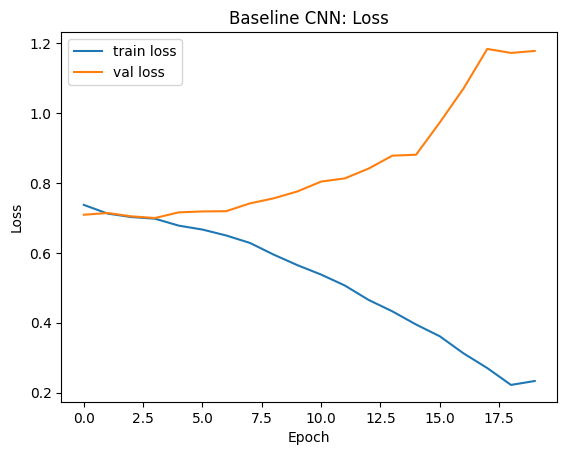

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Baseline CNN: Loss")
plt.legend(); plt.show()

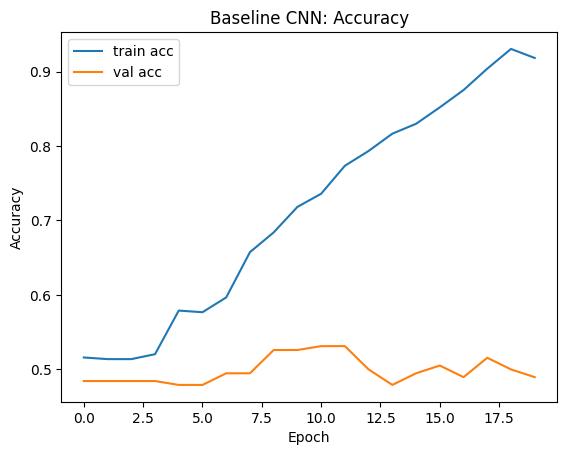

In [10]:

plt.figure()
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Baseline CNN: Accuracy")
plt.legend(); plt.show()

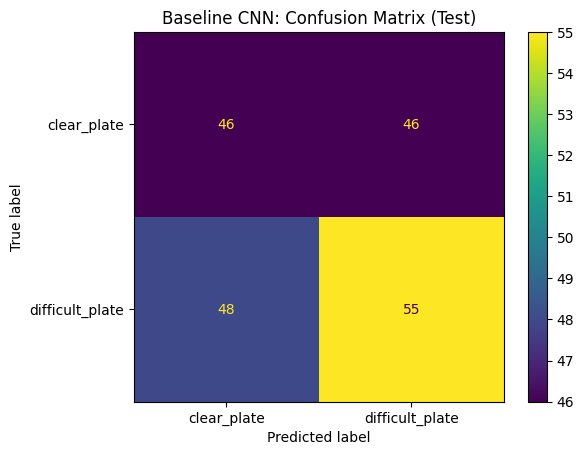

                 precision    recall  f1-score   support

    clear_plate       0.49      0.50      0.49        92
difficult_plate       0.54      0.53      0.54       103

       accuracy                           0.52       195
      macro avg       0.52      0.52      0.52       195
   weighted avg       0.52      0.52      0.52       195



In [11]:
y_true, y_pred = [], []
for x, y in test_ds:
    p = cnn.predict(x, verbose=0)
    y_true.extend(np.argmax(y.numpy(), axis=1))
    y_pred.extend(np.argmax(p, axis=1))

cm = confusion_matrix(y_true, y_pred)

# Identify unique classes present in the test set's true labels
# This ensures that the display_labels match the actual classes present in the confusion matrix
present_class_indices = sorted(np.unique(y_true).tolist())
filtered_display_labels = [class_names[i] for i in present_class_indices]

ConfusionMatrixDisplay(cm, display_labels=filtered_display_labels).plot(values_format="d")
plt.title("Baseline CNN: Confusion Matrix (Test)")
plt.show()

print(classification_report(y_true, y_pred, target_names=filtered_display_labels))

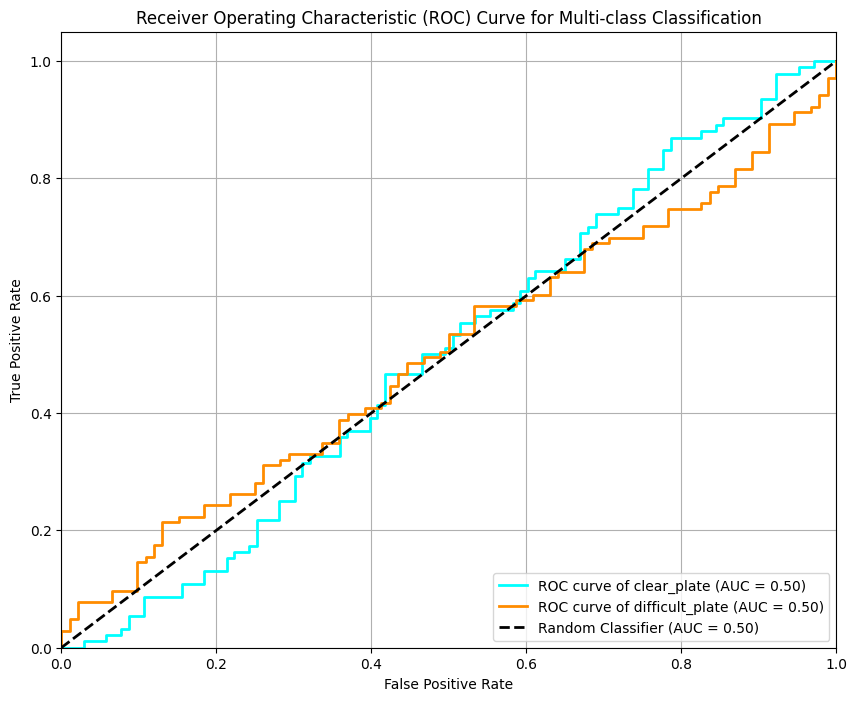

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import numpy as np
import tensorflow as tf

# Re-collect y_true (integer labels) and y_prob (prediction probabilities) from test_ds
# to ensure we have the full probability distributions needed for ROC curves.
all_y_true_labels = []
all_y_pred_probs = []

for images, labels in test_ds:
    # labels are already one-hot encoded by image_dataset_from_directory
    # Convert one-hot labels back to integer labels for all_y_true_labels list
    all_y_true_labels.extend(np.argmax(labels.numpy(), axis=1))
    all_y_pred_probs.extend(cnn.predict(images, verbose=0))

all_y_true_labels = np.array(all_y_true_labels)
all_y_pred_probs = np.array(all_y_pred_probs)

# Convert all_y_true_labels to one-hot encoding for ROC calculation
# Use the full class_names length for num_classes, as probabilities are for all classes.
y_true_one_hot = tf.keras.utils.to_categorical(all_y_true_labels, num_classes=len(class_names))

# Identify unique classes present in the test set's true labels
present_class_indices = sorted(np.unique(all_y_true_labels).tolist())

# Compute ROC curve and AUC for each *present* class
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple'])

for i, class_idx in enumerate(present_class_indices):
    # Use the appropriate column from the one-hot encoded true labels and prediction probabilities
    fpr[class_idx], tpr[class_idx], _ = roc_curve(y_true_one_hot[:, class_idx], all_y_pred_probs[:, class_idx])
    roc_auc[class_idx] = auc(fpr[class_idx], tpr[class_idx])

    plt.plot(fpr[class_idx], tpr[class_idx], color=next(colors), lw=2,
             label=f'ROC curve of {class_names[class_idx]} (AUC = {roc_auc[class_idx]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-class Classification')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

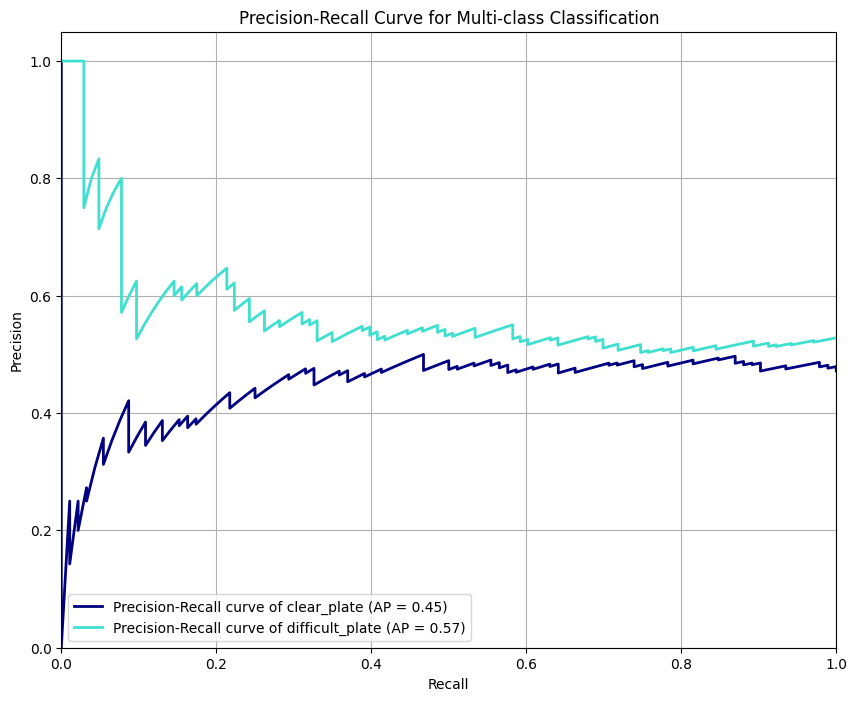

In [13]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute Precision-Recall curve and average precision for each present class
precision = dict()
recall = dict()
average_precision = dict()

plt.figure(figsize=(10, 8))
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red'])

for i, class_idx in enumerate(present_class_indices):
    precision[class_idx], recall[class_idx], _ = precision_recall_curve(y_true_one_hot[:, class_idx], all_y_pred_probs[:, class_idx])
    average_precision[class_idx] = average_precision_score(y_true_one_hot[:, class_idx], all_y_pred_probs[:, class_idx])

    plt.plot(recall[class_idx], precision[class_idx], color=next(colors), lw=2,
             label=f'Precision-Recall curve of {class_names[class_idx]} (AP = {average_precision[class_idx]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multi-class Classification')
plt.legend(loc="lower left")
plt.grid(True)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

# PART 2 — DETECTION (YOLO + “COMPARISON)

In [3]:
from pathlib import Path
import os, glob

ROOT = Path("/content/drive/MyDrive/Private Vehicles")
DET_ROOT = ROOT / "detection_dataset"

print("DET_ROOT exists:", DET_ROOT.exists())
print("images/train exists:", (DET_ROOT/"images/train").exists())
print("labels/train exists:", (DET_ROOT/"labels/train").exists())

# show what's inside images/train
train_path = DET_ROOT/"images/train"
if train_path.exists():
    files = list(train_path.glob("*"))
    print("files in images/train:", len(files))
    print("first 10:", [f.name for f in files[:10]])
else:
    print("images/train folder not found.")


DET_ROOT exists: True
images/train exists: True
labels/train exists: True
files in images/train: 904
first 10: ['IMG_2440_png.rf.34a40e1c8dcbf907889acce2d8e4053f.jpg', 'IMG_1806_png.rf.979871acb8afc5b5f80cd585b5803e58.jpg', 'ibrahim-234-_jpg.rf.67e649221e6202af75b62faa503f3dc6.jpg', 'IMG_2741_png.rf.0107ee8bf31f64a782e5239053e3ee0c.jpg', 'da-9-_png.rf.4f3ddd82ad09b41e5a43d14db358ade1.jpg', '-trashed-1733304817-IMG_20241104_120514_jpg.rf.9f559aa13d3eeb4f446a519816fe6a30.jpg', 'IMG_2965_png.rf.907f740a35c8925c0dc10abe52285fa9.jpg', 'IMG_2609_png.rf.d4795efec7178c5b114dd14040d39e23.jpg', 'IMG_1824_png.rf.82bf55ee18a256e99b2c1cccef02e554.jpg', '-trashed-1733303201-IMG_20241104_123009_jpg.rf.c0e8c2aba55f06a58c6c31f0506e6a70.jpg']


In [4]:
DET_ROOT = ROOT / "detection_dataset"

def check_detection_ready(det_root: Path):
    needed = [
        det_root/"images/train", det_root/"images/val", det_root/"images/test",
        det_root/"labels/train", det_root/"labels/val", det_root/"labels/test",
    ]
    missing = [p for p in needed if not p.exists()]
    if missing:
        print(" Detection dataset is NOT ready. Missing:")
        for m in missing:
            print(" -", m)
        return False
    print(" Detection dataset folders exist.")
    return True

DET_READY = check_detection_ready(DET_ROOT)


 Detection dataset folders exist.


In [5]:
from pathlib import Path

for split in ["train", "val", "test"]:
    (DET_ROOT / f"images/{split}").mkdir(parents=True, exist_ok=True)
    (DET_ROOT / f"labels/{split}").mkdir(parents=True, exist_ok=True)

print("✅ YOLO folders created:")
print(DET_ROOT / "images/train")
print(DET_ROOT / "labels/train")


✅ YOLO folders created:
/content/drive/MyDrive/Private Vehicles/detection_dataset/images/train
/content/drive/MyDrive/Private Vehicles/detection_dataset/labels/train


In [6]:
import random, shutil
from pathlib import Path

ROOT = Path("/content/drive/MyDrive/Private Vehicles")
DATA = ROOT / "data"
CLEAR = ROOT / "clear_plate"
DIFF = ROOT / "difficult_plate"

# collect images from best available source
def collect_images():
    exts = (".jpg", ".jpeg", ".png", ".bmp", ".webp")
    candidates = []
    for folder in [DATA, CLEAR, DIFF]:
        if folder.exists():
            candidates += [p for p in folder.rglob("*") if p.suffix.lower() in exts]
    return sorted(list(set(candidates)))

imgs = collect_images()
print("Total source images found:", len(imgs))
assert len(imgs) > 0, "No images found in data/clear_plate/difficult_plate."

# split 70/15/15
random.seed(42)
random.shuffle(imgs)

n = len(imgs)
n_train = int(0.70 * n)
n_val = int(0.15 * n)
train_imgs = imgs[:n_train]
val_imgs = imgs[n_train:n_train+n_val]
test_imgs = imgs[n_train+n_val:]

def copy_list(file_list, out_dir):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    for p in file_list:
        shutil.copy2(p, out_dir / p.name)

DET_ROOT = ROOT / "detection_dataset"
copy_list(train_imgs, DET_ROOT/"images/train")
copy_list(val_imgs,   DET_ROOT/"images/val")
copy_list(test_imgs,  DET_ROOT/"images/test")

print("✅ Copied:")
print("train:", len(list((DET_ROOT/'images/train').glob('*'))))
print("val:  ", len(list((DET_ROOT/'images/val').glob('*'))))
print("test: ", len(list((DET_ROOT/'images/test').glob('*'))))


Total source images found: 1292
✅ Copied:
train: 904
val:   193
test:  195


In [8]:
from pathlib import Path

DET_ROOT = Path("/content/drive/MyDrive/Private Vehicles/detection_dataset")

def count_labels(split):
    imgs = list((DET_ROOT/f"images/{split}").glob("*.*"))
    lbls = list((DET_ROOT/f"labels/{split}").glob("*.txt"))
    img_names = set([p.stem for p in imgs])
    lbl_names = set([p.stem for p in lbls])
    matched = len(img_names.intersection(lbl_names))
    return len(imgs), len(lbls), matched

for s in ["train","val","test"]:
    ni, nl, m = count_labels(s)
    print(f"{s}: images={ni}, labels={nl}, matched={m}")


train: images=904, labels=0, matched=0
val: images=193, labels=0, matched=0
test: images=195, labels=0, matched=0


In [9]:
!pip -q install ultralytics
from ultralytics import YOLO
from pathlib import Path
import torch

DET_ROOT = Path("/content/drive/MyDrive/Private Vehicles/detection_dataset")

data_yaml = Path("/content/data.yaml")
data_yaml.write_text(f"""
path: {DET_ROOT}
train: images/train
val: images/val
test: images/test
names:
  0: plate
""".strip())

device = 0 if torch.cuda.is_available() else "cpu"
print("Using device:", device)

yolo = YOLO("yolov8n.pt")
yolo.train(
    data=str(data_yaml),
    epochs=20,
    imgsz=640,
    batch=16,
    device=device,
    project="/content/runs",
    name="yolov8_plate",
    exist_ok=True
)


Using device: cpu
Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_plate, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plot

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:836: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/20         0G          0      64.52          0          0        640: 100% ━━━━━━━━━━━━ 57/57 14.3s/it 13:33
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 9.1s/it 1:04
                   all        193          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:836: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/20         0G          0      45.02          0          0        640: 100% ━━━━━━━━━━━━ 57/57 14.2s/it 13:27
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 8.5s/it 59.5s
                   all        193          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:836: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/20         0G          0      26.88          0          0        640: 100% ━━━━━━━━━━━━ 57/57 14.5s/it 13:44
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 8.8s/it 1:02
                   all        193          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:836: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       5/20         0G          0      14.74          0          0        640: 100% ━━━━━━━━━━━━ 57/57 14.3s/it 13:38
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 9.0s/it 1:03
                   all        193          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:836: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/20         0G          0      7.575          0          0        640: 100% ━━━━━━━━━━━━ 57/57 14.4s/it 13:42
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 8.7s/it 1:01
                   all        193          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:836: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/20         0G          0      3.852          0          0        640: 100% ━━━━━━━━━━━━ 57/57 14.4s/it 13:39
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 8.6s/it 1:00
                   all        193          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:836: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/20         0G          0       1.95          0          0        640: 100% ━━━━━━━━━━━━ 57/57 14.3s/it 13:36
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 8.8s/it 1:02
                   all        193          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:836: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       9/20         0G          0     0.9711          0          0        640: 100% ━━━━━━━━━━━━ 57/57 14.3s/it 13:33
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 8.7s/it 1:01
                   all        193          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:836: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/20         0G          0     0.4885          0          0        640: 100% ━━━━━━━━━━━━ 57/57 14.4s/it 13:43
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 8.5s/it 59.2s
                   all        193          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:836: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      11/20         0G          0     0.2504          0          0        640: 100% ━━━━━━━━━━━━ 57/57 14.0s/it 13:20
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 8.9s/it 1:02
                   all        193          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:836: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      12/20         0G          0     0.1402          0          0        640: 100% ━━━━━━━━━━━━ 57/57 14.4s/it 13:40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 8.8s/it 1:01
                   all        193          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:836: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      13/20         0G          0    0.07354          0          0        640: 100% ━━━━━━━━━━━━ 57/57 14.1s/it 13:22
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 9.1s/it 1:04
                   all        193          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:836: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      14/20         0G          0     0.0294          0          0        640: 100% ━━━━━━━━━━━━ 57/57 14.2s/it 13:32
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 8.6s/it 59.9s
                   all        193          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:836: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      15/20         0G          0    0.02405          0          0        640: 100% ━━━━━━━━━━━━ 57/57 14.3s/it 13:35
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 8.7s/it 1:01
                   all        193          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:836: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      16/20         0G          0    0.02145          0          0        640: 100% ━━━━━━━━━━━━ 57/57 14.3s/it 13:37
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 9.0s/it 1:03
                   all        193          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:836: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      17/20         0G          0    0.01895          0          0        640: 100% ━━━━━━━━━━━━ 57/57 14.1s/it 13:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 8.7s/it 1:01
                   all        193          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:836: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      18/20         0G          0    0.01047          0          0        640: 100% ━━━━━━━━━━━━ 57/57 14.1s/it 13:22
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 8.7s/it 1:01
                   all        193          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:836: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      19/20         0G          0   0.006442          0          0        640: 100% ━━━━━━━━━━━━ 57/57 14.2s/it 13:32
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 8.6s/it 60.0s
                   all        193          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:836: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      20/20         0G          0   0.006098          0          0        640: 100% ━━━━━━━━━━━━ 57/57 14.0s/it 13:20
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 8.6s/it 1:00
                   all        193          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:836: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



20 epochs completed in 4.865 hours.
Optimizer stripped from /content/runs/yolov8_plate/weights/last.pt, 6.2MB
Optimizer stripped from /content/runs/yolov8_plate/weights/best.pt, 6.2MB

Validating /content/runs/yolov8_plate/weights/best.pt...
Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 8.0s/it 56.2s


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:654: RuntimeWarning: Mean of empty slice.
  ax.plot(px, py.mean(1), linewidth=3, color="blue", label=f"all classes {ap[:, 0].mean():.3f} mAP@0.5")
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:700: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:700: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.12/dist-packages/ultraly

                   all        193          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels
Speed: 2.7ms preprocess, 271.6ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /content/runs/yolov8_plate


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([], dtype=int64)
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bb075f6d400>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

In [10]:
best = Path("/content/runs/detect/yolov8_plate/weights/best.pt")
detector = YOLO(str(best))

val_metrics = detector.val(data=str(data_yaml), split="val")
test_metrics = detector.val(data=str(data_yaml), split="test")

print("YOLO VAL metrics:", val_metrics)
print("YOLO TEST metrics:", test_metrics)

# Save qualitative images
pred_dir = Path("/content/predictions_yolo")
pred_dir.mkdir(exist_ok=True)

detector.predict(
    source=str(DET_ROOT/"images/test"),
    conf=0.25,
    save=True,
    project=str(pred_dir),
    name="test_vis",
    exist_ok=True
)
print("✅ Saved predictions:", pred_dir/"test_vis")

FileNotFoundError: [Errno 2] No such file or directory: '/content/runs/detect/yolov8_plate/weights/best.pt'

In [ ]:
!pip -q install opencv-python
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random

test_imgs = sorted(list((DET_ROOT/"images/test").glob("*.*")))
sample = random.sample(test_imgs, k=min(6, len(test_imgs)))

def classical_plate_candidates(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)
    edged = cv2.Canny(gray, 30, 200)

    cnts, _ = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:10]

    boxes = []
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:  # rectangular candidate
            x, y, w, h = cv2.boundingRect(approx)
            if w > 60 and h > 15:  # simple filter
                boxes.append((x, y, x+w, y+h))
    return boxes

plt.figure(figsize=(12, 8))
for i, p in enumerate(sample):
    img = cv2.imread(str(p))
    boxes = classical_plate_candidates(img)

    for (x1, y1, x2, y2) in boxes[:1]:
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 3, i+1)
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title("Classical candidate")
plt.tight_layout()
plt.show()
